# Time-dependent Schrödinger Equation

Consider the time-dependent one-dimensional quantum harmonic oscillator defined by the Hamiltonian:

$$
\hat{H} = \frac{\hat{p}^2}{2m} + \frac{\omega^2}{2m} \left( \hat{q} - q_0(t) \right)^2, \qquad \qquad \text{where} \quad q_0(t) = \frac{t}{T}, \quad t \in [0, T].

$$

Given the initial state as the ground state of the harmonic oscillator $ |\Psi_0\rangle = |n = 0\rangle $, compute the time-evolved wavefunction $|\Psi(t)\rangle$ for different <br> values of $T$. Plot the square norm of $|\Psi(t)\rangle$ as a function of $q$ at different times, and the average position of the particle as a function of $t$.


In [1]:
import qho_time_evolution as qhote

## Real time evolution

In [2]:
# SIMULATION PARAMETERS

xmin = -5.0
xmax = 5.0
num_x = 1000
tsim = 200
num_t = 1000
im_time = False

# Initialize the Param object
par = qhote.Param(xmin, xmax, num_x, tsim, num_t, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

res = num_x
voffset = 0.0
wfcoffset = 0.0
omega = 2.0
order = 8
n = 0
q0_func = lambda t: t / tsim 

# Initialize the Operators object
opr = qhote.Operators(res, voffset, wfcoffset, omega, order, n, q0_func, par)

In [3]:
print(f"The final energy of the systems is: {opr.energy_history[-1]}")

The final energy of the systems is: 1.000000000000022


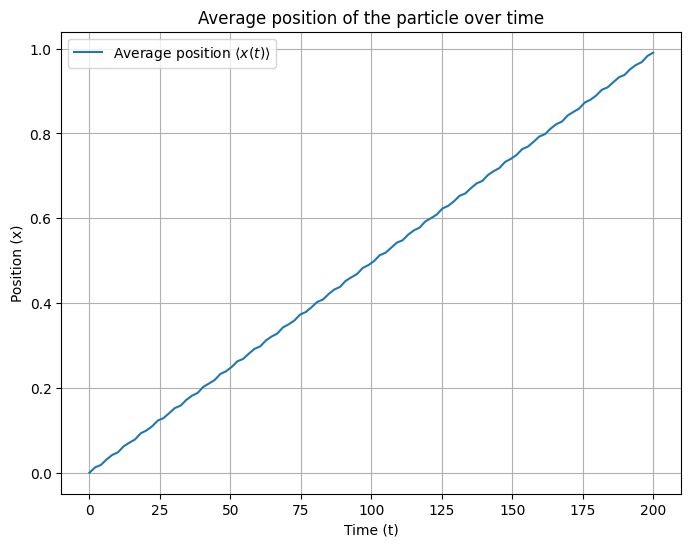

In [4]:
# Run the simulation and get the results
density, potential, avg_position = qhote.split_op(par, opr)

qhote.plot_average_position(par, avg_position)

In [5]:
filename = "real_time_evolution.gif"
qhote.gif_animation(par, density, potential, avg_position, filename)

Animation saved as 'real_time_evolution.gif'


## Imaginary time evolution

In [6]:
# SIMULATION PARAMETERS

xmin = -5.0
xmax = 5.0
num_x = 1000
tsim = 500
num_t = 10000
im_time = True

# Initialize the Param object
par = qhote.Param(xmin, xmax, num_x, tsim, num_t, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

res = num_x
voffset = 0.0
wfcoffset = 0.0
omega = 2.0
order = 8
n = 0
q0_func = lambda t: t / tsim 

# Initialize the Operators object
opr = qhote.Operators(res, voffset, wfcoffset, omega, order, n, q0_func, par)

In [7]:
print(f"The final energy of the systems is: {opr.energy_history[-1]}")

The final energy of the systems is: 1.000000000000022


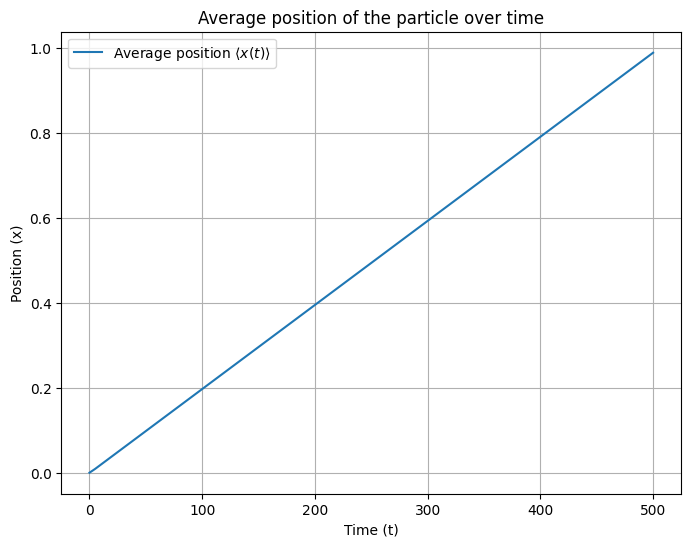

In [8]:
# Run the simulation and get the results
density, potential, avg_position = qhote.split_op(par, opr)

qhote.plot_average_position(par, avg_position)

In [9]:
filename = "imaginary_time_evolution.gif"
qhote.gif_animation(par, density, potential, avg_position, filename)

Animation saved as 'imaginary_time_evolution.gif'
